## CPU Inference on ONNX Runtime on Azure Kubernetes Service
Vision Transformer converted to ONNXs

This example shows how to deploy an image classification neural network using ONNX Runtime on GPU compute SKUs in Azur In this example we use a Vision Transformer fine tuned with a custom datased to detect images non-safe for workrme


### EyeQ --> https://github.com/HzFu/EyeQ/tree/master
#### Citacion
[1] Huazhu Fu, Boyang Wang, Jianbing Shen, Shanshan Cui, Yanwu Xu, Jiang Liu, Ling Shao, "Evaluation of Retinal Image Quality Assessment Networks in Different Color-spaces", in MICCAI, 2019. [PDF] Note: The corrected accuracy score of MCF-Net is 0.8800.

### EyePacs
https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview

#### 1. Prerequisites to install A
Please restart kernel after pip installs to sync environment with new modules.

In [1]:
#! pip install matplotlib onnx opencv-python
# pip install azure-ai-ml azure-identity datasets azure-cli mlflow

#### 2. Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

For this lab, we've already setup an AzureML Workspace for you. If you'd like to learn more about `Workspace`s, please reference [`AzureML's documentation`](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace?view=azureml-api-2&tabs=azure-portal).

We are using the `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [`Set up authentication`](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk&view=azureml-api-2) for more available credentials.

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml import Input
from azure.ai.ml.dsl import pipeline
from dotenv import dotenv_values
from dotenv import load_dotenv
from utils.login import get_ws_client
from utils.datasets import get_labels_dataset, create_datasets
from utils.computer import create_gpu_cluster
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

### .env file to use your service principal account

```md
RESOURCE_GROUP=
SUBSCRIPTION_ID=
AZUREML_WORKSPACE_NAME=
TENANTID=
AZURE_CLIENT_ID=
AZURE_TENANT_ID=
AZURE_CLIENT_SECRET=
```

In [8]:
# Load env and login to Workspace
load_dotenv(".env")
config = dotenv_values(".env")


# Enter details of your Azure Machine Learning workspace
subscription_id = config.get("SUBSCRIPTION_ID")
resource_group = config.get("RESOURCE_GROUP")
workspace ="azure-ml-2"

In [9]:
credential = DefaultAzureCredential()
# Check if given credential can get token successfully.
credential.get_token("https://management.azure.com/.default")


ml_client = get_ws_client(
    credential, subscription_id, resource_group, workspace
)
print(ml_client)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x00000202ECA78F10>,
         subscription_id=5a8ec57c-47f9-4bc3-aee5-9e4db1b89345,
         resource_group_name=olonok-ml,
         workspace_name=azure-ml-2)


#### Repository https://github.com/olonok69/LLM_Notebooks/tree/main/image/EyePacs
#### Quality Model
(I)https://youtu.be/QGJ5bkWgvp4

(E)https://youtu.be/bh7SvuYRqqY
#### Detection Model
(I)https://youtu.be/Qe97G4dvIPE

(E)https://youtu.be/eisFp0OwNyI
#### Convert Models to ONNX
(I)https://youtu.be/wVCVT8svFVI

(E)https://youtu.be/IP9u3d4Ggd0



# Models

In [10]:
path_model_detection ="models/onnx/retina_detection.onnx"
path_model_quality ="models/onnx/retina_quality.onnx"

#### Load Azure ML workspace



In [11]:
# Check core SDK version number
import azureml.core
from azureml.core import Workspace
print("SDK version:", azureml.core.VERSION)


SDK version: 1.57.0


In [14]:
from azureml.core import Workspace

# read existing workspace from config.json
ws = Workspace(subscription_id=subscription_id, resource_group=resource_group, workspace_name=workspace)

print(ws.subscription_id, ws.location, ws.resource_group, ws.name, sep = '\n')

5a8ec57c-47f9-4bc3-aee5-9e4db1b89345
uksouth
olonok-ml
azure-ml-2


#### Register your ONNX model with Azure ML



In [15]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes


# Model Quality

In [57]:

file_model = Model(
    path= path_model_quality,
    type=AssetTypes.CUSTOM_MODEL,
    name="retina_quality",
    description= "Quality Model Retina onnx format",
    tags={"type": "vit-base-patch16-224-in21k", "format":"onnx"}
)
ml_client.models.create_or_update(file_model)



Uploading retina_quality.onnx (< 1 MB): 277MB [09:09, 503kB/s]                                                                                                                     




Model({'job_name': None, 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'retina_quality', 'description': 'Quality Model Retina onnx format', 'tags': {'type': 'vit-base-patch16-224-in21k', 'format': 'onnx'}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/azure-ml-2/models/retina_quality/versions/2', 'Resource__source_path': None, 'base_path': 'F:\\repos\\test_retina', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x00000202FA461FD0>, 'serialize': <msrest.serialization.Serializer object at 0x00000202FC917DD0>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/workspaces/azure-ml-2/datastores/workspaceblobstore/paths/LocalUpload/576662ad3dc80deb936bba22024c686f/retina_q

# Detection Model

In [17]:
file_model = Model(
    path= path_model_detection,
    type=AssetTypes.CUSTOM_MODEL,
    name="retina_detection",
    description= "Detection Model Retina onnx format",
    tags={"type": "vit-base-patch16-224-in21k", "format":"onnx"}
)
ml_client.models.create_or_update(file_model)

Uploading retina_detection.onnx (< 1 MB): 277MB [09:19, 495kB/s]                                                                                                                   




Model({'job_name': None, 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'retina_detection', 'description': 'Detection Model Retina onnx format', 'tags': {'type': 'vit-base-patch16-224-in21k', 'format': 'onnx'}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/azure-ml-2/models/retina_detection/versions/1', 'Resource__source_path': None, 'base_path': 'F:\\repos\\test_retina', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x00000202CC194250>, 'serialize': <msrest.serialization.Serializer object at 0x00000202CBFE5410>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/workspaces/azure-ml-2/datastores/workspaceblobstore/paths/LocalUpload/145da69b02f30b20bb5d2ad77b7cc1c8/re

In [18]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: vivit_classifier 	Version: 1 	Description: Video classification {'type': 'google/vivit-b-16x2-kinetics400', 'format': 'onnx', 'fine_tuned': '10 classes from https://www.crcv.ucf.edu/research/data-sets/ucf101/'}
Name: retina_quality 	Version: 1 	Description: Quality Model Retina onnx format {'type': 'vit-base-patch16-224-in21k', 'format': 'onnx'}
Name: retina_detection 	Version: 1 	Description: Detection Model Retina onnx format {'type': 'vit-base-patch16-224-in21k', 'format': 'onnx'}


In [19]:
# Inference test in Local

In [47]:
def get_key(dict, value):
    """
    return key given a value. From a dictionary
    """
    for key, val in dict.items():
        if val == value:
            return key
    return "Value not found"

# Process Request

In [23]:
from transformers import ViTFeatureExtractor, ViTImageProcessor
import onnxruntime
import json
import base64
import io
import numpy as np
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, do_normalize =False, do_rescale=True )

In [22]:
path_image = 'F:\\repos\\test_retina\\dr\\train\\DR\\20619_right.jpeg'

In [24]:
with open(path_image, "rb") as f:
    video = f.read()
    f.close()
    im_b64 = base64.b64encode(video).decode("utf-8")

In [25]:
input_data = json.dumps({'data': im_b64})
requests_json = json.loads(input_data.encode())

In [31]:
from PIL import Image , ImageOps
image_bytes = base64.b64decode(requests_json.get("data").encode("utf-8"))

image_bytes[:30]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01'

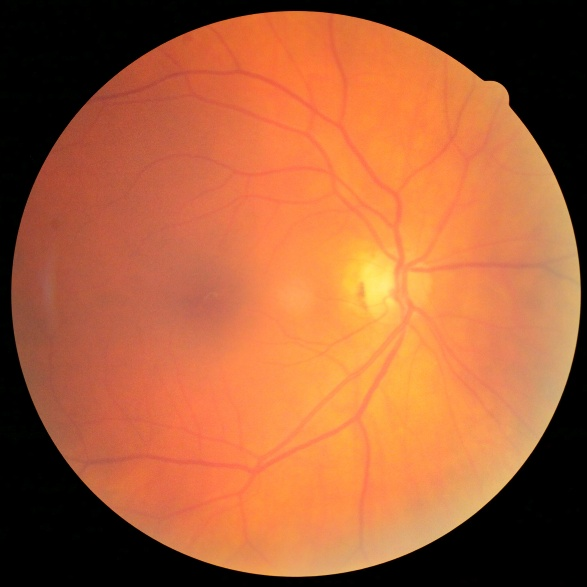

In [34]:
image= Image.open(io.BytesIO(image_bytes))
image

In [35]:
imf = feature_extractor(image, return_tensors='pt')

In [99]:
imf['pixel_values'].shape

torch.Size([1, 3, 224, 224])

# QUALITY MODEL

In [49]:
ort_sess = onnxruntime.InferenceSession(
    path_model_quality, providers=["CPUExecutionProvider"]
)


input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

In [50]:
inputs_t = np.array( feature_extractor(image, return_tensors='pt')['pixel_values'])

In [51]:
inputs_t.shape

(1, 3, 224, 224)

In [52]:
outputs = ort_sess.run([output_name], {input_name: inputs_t})[0]

In [53]:
outputs

array([[ 2.0994668 , -0.76872927, -1.3989451 ]], dtype=float32)

In [54]:
label_dic_quality ={"good":0, "usable": 1,"reject":2}
# Get Logits
logits = np.array(outputs)
# Get Probabilities
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
# Get Pedicted Class
predicted_class = np.argmax(probabilities, axis=1)

In [55]:
predicted_class

array([0], dtype=int64)

In [56]:
print(f"Predicted classes: {predicted_class[0]}, label: { get_key(label_dic_quality, predicted_class[0])}")
print("\n")
output_probs = {}
print("All Probabilities:")
for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
    label = get_key(label_dic_quality, key)
    output_probs[label] = float(prob)

print(output_probs)

Predicted classes: 0, label: good


All Probabilities:
{'good': 0.9199236035346985, 'usable': 0.05225285887718201, 'reject': 0.027823438867926598}


In [59]:
output_probs['reject']>= 0.33

False

# Detection Model if reject < 0.33

In [60]:
ort_sess_detection = onnxruntime.InferenceSession(
    path_model_detection, providers=["CPUExecutionProvider"]
)


input_name = ort_sess_detection.get_inputs()[0].name
output_name = ort_sess_detection.get_outputs()[0].name

In [61]:
inputs_t = np.array( feature_extractor(image, return_tensors='pt')['pixel_values'])

In [63]:
outputs = ort_sess_detection.run([output_name], {input_name: inputs_t})[0]
outputs

array([[ 0.314541  , -0.32192504]], dtype=float32)

In [64]:
label_dic_detection ={"NO_DR":0, "DR":1}
# Get Logits
logits = np.array(outputs)
# Get Probabilities
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
# Get Pedicted Class
predicted_class = np.argmax(probabilities, axis=1)
predicted_class

array([0], dtype=int64)

In [65]:
print(f"Predicted classes: {predicted_class[0]}, label: { get_key(label_dic_detection, predicted_class[0])}")
print("\n")
output_probs = {}
print("All Probabilities:")
for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
    label = get_key(label_dic_detection, key)
    output_probs[label] = float(prob)

print(output_probs)

Predicted classes: 0, label: NO_DR


All Probabilities:
{'NO_DR': 0.6539542078971863, 'DR': 0.3460458219051361}


#### Create Scoring file

In [90]:
%%writefile models/onnx/score.py
import json
import numpy as np
import onnxruntime
import sys
import os
from azureml.core.model import Model
import time
from transformers import ViTImageProcessor
import base64
import io
from PIL import Image


def init():
    global qsession, input_nameq, output_nameq, dsession, input_named, output_named, feature_extractor, label_dic_quality, label_dic_detection
    path_model_detection ="retina_detection.onnx"
    path_model_quality ="retina_quality.onnx"
    # Load the model QUALITY   
    qsession = onnxruntime.InferenceSession(path_model_quality, providers=["CPUExecutionProvider"])
    input_nameq = qsession.get_inputs()[0].name
    output_nameq = qsession.get_outputs()[0].name 
    # Load the model Detection   
    dsession = onnxruntime.InferenceSession(path_model_detection, providers=["CPUExecutionProvider"])
    input_named = dsession.get_inputs()[0].name
    output_named = dsession.get_outputs()[0].name 
    model_name_or_path = 'google/vit-base-patch16-224-in21k'
    feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, do_normalize =False, do_rescale=True )
    label_dic_quality ={"good":0, "usable": 1,"reject":2}
    label_dic_detection ={"NO_DR":0, "DR":1}
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''

    try:
        # load in our data, convert to readable format
        requests_json = json.loads(input_data.encode("utf-8"))
        
        image_bytes = base64.b64decode(requests_json.get("data"))
        image= Image.open(io.BytesIO(image_bytes))
        inputs_t = np.array( feature_extractor(image, return_tensors='pt')['pixel_values'])
        
        
        # pass input data to do model inference with ONNX Runtime Quality Model
        start = time.time()
        outputsq = qsession.run([output_nameq], {input_nameq: inputs_t})[0]       
        logits, probabilities, predicted_class = get_probs(outputsq)
        output_quality = label_map(predicted_class=predicted_class, label_dic=label_dic_quality, probabilities=probabilities)
        # If probability reject < .33
        output_detection = {}
        if output_quality['reject']< 0.33:
            outputsd = dsession.run([output_named], {input_named: inputs_t})[0]       
            logits, probabilities, predicted_class = get_probs(outputsd)
            output_detection = label_map(predicted_class=predicted_class, label_dic=label_dic_detection, probabilities=probabilities)
            
        
        end = time.time()
        if output_detection.keys() == 0:
            output_detection = {"output": "not posible Output due to low quality Image"}
        result_dict = {"result_quality": output_quality,
                       "result_detection": output_detection,
                      "time_in_sec": [end - start]}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return json.dumps(result_dict)



def label_map(predicted_class, label_dic, probabilities, threshold=.5):
    """Take the most probable labels (output of postprocess) and returns the 
    probs of each label."""
    print(f"Predicted classes: {predicted_class[0]}, label: { get_key(label_dic, predicted_class[0])}")
    print("\n")
    output_probs = {}
    print("All Probabilities:")
    for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
        label = get_key(label_dic, key)
        output_probs[label] = float(prob)
    
    return output_probs

def get_key(dict, value):
    """
    return key given a value. From a dictionary
    """
    for key, val in dict.items():
        if val == value:
            return key
    return "Value not found"


def get_probs(outputs):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""

    # Get Logits
    logits = np.array(outputs)
    # Get Probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    # Get Pedicted Class
    predicted_class = np.argmax(probabilities, axis=1)
    
    return logits, probabilities, predicted_class



Overwriting models/onnx/score.py


In [77]:
import json
import numpy as np
import onnxruntime
import sys
import os
from azureml.core.model import Model
import time
from transformers import ViTImageProcessor
import base64
import io
from PIL import Image


def init():
    global qsession, input_nameq, output_nameq, dsession, input_named, output_named, feature_extractor, label_dic_quality, label_dic_detection
    path_model_detection ="models/onnx/retina_detection.onnx"
    path_model_quality ="models/onnx/retina_quality.onnx"
    # Load the model QUALITY   
    qsession = onnxruntime.InferenceSession(path_model_quality, providers=["CPUExecutionProvider"])
    input_nameq = qsession.get_inputs()[0].name
    output_nameq = qsession.get_outputs()[0].name 
    # Load the model Detection   
    dsession = onnxruntime.InferenceSession(path_model_detection, providers=["CPUExecutionProvider"])
    input_named = dsession.get_inputs()[0].name
    output_named = dsession.get_outputs()[0].name 
    model_name_or_path = 'google/vit-base-patch16-224-in21k'
    feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, do_normalize =False, do_rescale=True )
    label_dic_quality ={"good":0, "usable": 1,"reject":2}
    label_dic_detection ={"NO_DR":0, "DR":1}
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''

    try:
        # load in our data, convert to readable format
        requests_json = json.loads(input_data.encode("utf-8"))
        
        image_bytes = base64.b64decode(requests_json.get("data"))
        image= Image.open(io.BytesIO(image_bytes))
        inputs_t = np.array( feature_extractor(image, return_tensors='pt')['pixel_values'])
        
        
        # pass input data to do model inference with ONNX Runtime Quality Model
        start = time.time()
        outputsq = qsession.run([output_nameq], {input_nameq: inputs_t})[0]       
        logits, probabilities, predicted_class = get_probs(outputsq)
        output_quality = label_map(predicted_class=predicted_class, label_dic=label_dic_quality, probabilities=probabilities)
        # If probability reject < .33
        output_detection = {}
        if output_quality['reject']< 0.33:
            outputsd = dsession.run([output_named], {input_named: inputs_t})[0]       
            logits, probabilities, predicted_class = get_probs(outputsd)
            output_detection = label_map(predicted_class=predicted_class, label_dic=label_dic_detection, probabilities=probabilities)
            
        
        end = time.time()
        if output_detection.keys() == 0:
            output_detection = {"output": "not posible Output due to low quality Image"}
        result_dict = {"result_quality": output_quality,
                       "result_detection": output_detection, "time_in_sec": [end - start]}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return json.dumps(result_dict)



def label_map(predicted_class, label_dic, probabilities, threshold=.5):
    """Take the most probable labels (output of postprocess) and returns the 
    probs of each label."""
    print(f"Predicted classes: {predicted_class[0]}, label: { get_key(label_dic, predicted_class[0])}")
    print("\n")
    output_probs = {}
    print("All Probabilities:")
    for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
        label = get_key(label_dic, key)
        output_probs[label] = float(prob)
    
    return output_probs

def get_key(dict, value):
    """
    return key given a value. From a dictionary
    """
    for key, val in dict.items():
        if val == value:
            return key
    return "Value not found"


def get_probs(outputs):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""

    # Get Logits
    logits = np.array(outputs)
    # Get Probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    # Get Pedicted Class
    predicted_class = np.argmax(probabilities, axis=1)
    
    return logits, probabilities, predicted_class

In [74]:
init()

In [78]:
input_data = json.dumps({'data': im_b64})
run(input_data)

Predicted classes: 0, label: good


All Probabilities:
Predicted classes: 0, label: NO_DR


All Probabilities:


'{"result_quality": {"good": 0.9199236035346985, "usable": 0.05225285887718201, "reject": 0.027823438867926598}, "result_detection": {"NO_DR": 0.6539542078971863, "DR": 0.3460458219051361}, "time_in_sec": [0.6710004806518555]}'

##### Create Endpoint

In [80]:
import onnxruntime

In [82]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
# Define an endpoint name
endpoint_name = "endpt-retina-detection-onnx"

# # Example way to define a random name
# import datetime

#endpoint_name = "endpt-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name = endpoint_name, 
    description="this is a endpoint for onnx inference Retina Eyepacs model",
    auth_mode="key"
)

ml_client.online_endpoints.begin_create_or_update(endpoint).wait()
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpt-retina-detection-onnx.uksouth.inference.ml.azure.com/score', 'openapi_uri': 'https://endpt-retina-detection-onnx.uksouth.inference.ml.azure.com/swagger.json', 'name': 'endpt-retina-detection-onnx', 'description': 'this is a endpoint for onnx inference Retina Eyepacs model', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourcegroups/olonok-ml/providers/microsoft.machinelearningservices/workspaces/azure-ml-2/onlineendpoints/endpt-retina-detection-onnx', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/providers/Microsoft.MachineLearningServices/locations/uksouth/mfeOperationsStatus/oeidp:31ae886d-ee28-4a4f-af29-64989f2a9076:7a2c07ea-c316-4b1c-a567-2f629a0b6b0e?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/5a8ec57c

In [84]:
for m in ml_client.models.list():
    print(m)

creation_context:
  created_at: '2024-09-18T13:07:49.515208+00:00'
  created_by: 947fca35-35c1-4316-af96-dc987ad57f98
  created_by_type: Application
  last_modified_at: '2024-09-18T13:07:49.515208+00:00'
  last_modified_by: 947fca35-35c1-4316-af96-dc987ad57f98
  last_modified_by_type: Application
id: azureml:/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/azure-ml-2/models/vivit_classifier
latest_version: '1'
name: vivit_classifier
properties: {}
tags: {}
type: custom_model

creation_context:
  created_at: '2024-10-07T09:32:23.966434+00:00'
  created_by: 947fca35-35c1-4316-af96-dc987ad57f98
  created_by_type: Application
  last_modified_at: '2024-10-07T09:32:23.966434+00:00'
  last_modified_by: 947fca35-35c1-4316-af96-dc987ad57f98
  last_modified_by_type: Application
id: azureml:/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/works

In [ ]:
#case we need to create the env
# env = Environment(
#     build=BuildContext(path="docker"),
#     name="docker-vivit",
#     description="Environment Vivit.",
# )
# env_log= ml_client.environments.create_or_update(env)

In [86]:
# Get Env
env = ml_client.environments.get(name="docker-vivit", version="2")
model = ml_client.models.get(name="retina_quality", version = 2)

In [74]:
#ml_client.models.download(name="onnx_emotion", version = 1)

##### 9.3 Deploy scoring file to the endpoint

In [87]:
model.name, model.version

('retina_quality', '2')

In [88]:
endpoint_name

'endpt-retina-detection-onnx'

In [89]:
env

Environment({'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'docker-vivit', 'description': 'Environment Vivit.', 'tags': {}, 'properties': {'azureml.labels': ''}, 'print_as_yaml': True, 'id': '/subscriptions/5a8ec57c-47f9-4bc3-aee5-9e4db1b89345/resourceGroups/olonok-ml/providers/Microsoft.MachineLearningServices/workspaces/azure-ml-2/environments/docker-vivit/versions/2', 'Resource__source_path': None, 'base_path': 'F:\\repos\\test_retina', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000020280D3B050>, 'serialize': <msrest.serialization.Serializer object at 0x0000020283DB9F50>, 'version': '2', 'latest_version': None, 'conda_file': None, 'image': None, 'build': <azure.ai.ml.entities._assets.environment.BuildContext object at 0x0000020283DE26D0>, 'inference_config': None, 'os_type': 'Linux', 'arm_type': 'environment_version', 'conda_file_path': None, 'path': None, 'datastore': N

In [ ]:
Model.

In [91]:


blue_deployment = ManagedOnlineDeployment(
    name="retina-onnx",
    endpoint_name=endpoint_name,
    model=model,
    environment=env,
    code_configuration=CodeConfiguration(
        code="./models/onnx", scoring_script="score.py"
    ),
    instance_type="Standard_NC4as_T4_v3",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(blue_deployment)

Check: endpoint endpt-retina-detection-onnx exists
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'F:\repos\test_retina\models\onnx' 'https://azureml27454141413.blob.core.windows.net/31ae886d-ee28-4a4f-af29-64989f2a9076-9g7pvlxdmhscgcedij0u05rudz/onnx' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Uploading onnx (687.0 MBs): 100%|################################################################################################| 687004904/687004904 [18:31<00:00, 618231.60it/s]




..........................................................................................................................................


#### Documentation: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-online-endpoints
#### Troubleshooting: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-online-endpoints
  


In [93]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) 

In [100]:
body = str.encode(input_data)

In [101]:


body = str.encode(input_data)

url = "https://endpt-retina-detection-onnx.uksouth.inference.ml.azure.com/score"
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = "g9mpLCn2oVSfXgABaw937Bs2Zquleqbf"
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")


headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'retina-onnx' }

req = urllib.request.Request(url, body, headers)
try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'"{\\"result_quality\\": {\\"good\\": 0.9199236035346985, \\"usable\\": 0.05225285887718201, \\"reject\\": 0.027823438867926598}, \\"result_detection\\": {\\"NO_DR\\": 0.6539542078971863, \\"DR\\": 0.3460458219051361}, \\"time_in_sec\\": [0.5705046653747559]}"'


In [102]:
json.loads(result.decode())

'{"result_quality": {"good": 0.9199236035346985, "usable": 0.05225285887718201, "reject": 0.027823438867926598}, "result_detection": {"NO_DR": 0.6539542078971863, "DR": 0.3460458219051361}, "time_in_sec": [0.5705046653747559]}'

##### 9.5: Delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint

In [147]:
ml_client.online_endpoints.begin_delete(name=endpoint_name).wait()

........................................................................